In [1]:
from dataset_util.reader import Dataset
import matplotlib.pyplot as plt
from pose_estimation.estimation import PoseEstimator, fix_scale
import numpy as np
from mpl_toolkits import mplot3d
from plot_util.plot import plot_positions, plot_poses
from dataset_util.pose import Pose
import cv2 

In [2]:
dataset_path = "./datasets/living_room_traj2_frei_png"
dataset = Dataset(dataset_path)

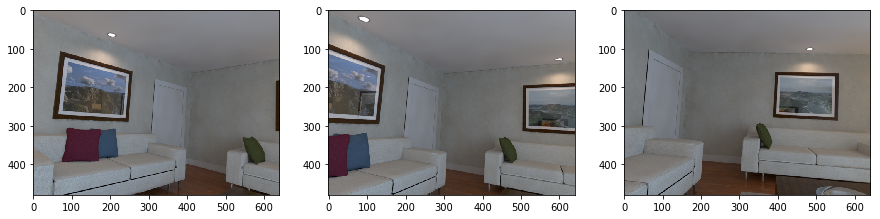

In [3]:
step = 40
start = 143
indices = [start, start + step, start + 2*step]
images = [dataset.image_at(idx) for idx in indices]

# Show to images
plt.figure(figsize=(15, 15))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(images[i-1])

In [4]:
relative_poses = [dataset.relative_pose(i, i+step) for i in indices[:2]]
for i, rp in enumerate(relative_poses):
    print("relative pose {}:".format(i))
    print(rp)

relative pose 0:
[[ 0.95062314 -0.02463692  0.30936816 -0.36703284]
 [ 0.02211118  0.99968742  0.01166837 -0.0220447 ]
 [-0.30955894 -0.00425173  0.95087075  0.30268042]
 [ 0.          0.          0.          1.        ]]
relative pose 1:
[[ 0.93873186 -0.01814893  0.34417017 -0.40064886]
 [ 0.04084145  0.99743404 -0.05879885 -0.08357148]
 [-0.34221991  0.06925276  0.93706435  0.40868352]
 [ 0.          0.          0.          1.        ]]


In [5]:
# Estimate relative poses
K = np.array([[481.20, 0, 319.50],
              [0, -480.00, 239.50],
              [0, 0, 1]])
pose_estimator = PoseEstimator(K=K, method="SIFT")
estimate_0 = fix_scale(relative_poses[0], pose_estimator.estimate(images[0], images[1]))
estimate_1 = fix_scale(relative_poses[1], pose_estimator.estimate(images[1], images[2]))
# estimate_1 = pose_estimator.estimate(images[1], images[2])
estimates = [estimate_0, estimate_1]
for i, rp in enumerate(estimates):
    print("estimate relative pose {}:".format(i))
    print(rp)

estimate relative pose 0:
[[ 0.94981565 -0.02293712  0.31196813 -0.36609406]
 [ 0.01934565  0.99970621  0.01460269 -0.03229483]
 [-0.31221142 -0.00783463  0.94998034  0.30289717]
 [ 0.          0.          0.          1.        ]]
estimate relative pose 1:
[[ 0.94284746 -0.01291055  0.33297446 -0.40233884]
 [ 0.03578534  0.99739335 -0.06265712 -0.06790168]
 [-0.33129758  0.07099171  0.94085179  0.40992528]
 [ 0.          0.          0.          1.        ]]


In [6]:
# Construct poses
poses = [Pose() for _ in range(3)]
poses[1] = relative_poses[0]
poses[2] = poses[1] * relative_poses[1]
est_poses = [Pose() for _ in range(3)]
est_poses[1] = estimates[0]
est_poses[2] = est_poses[1] * estimates[1]

In [7]:
# %matplotlib notebook
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection="3d")
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# fig.canvas.draw()
# plot_poses(ax, poses, length=1, style="--")
# plot_poses(ax, est_poses, length=1, style="-")
# plt.show()

In [8]:
# Get good keypoints
E1, pts1, pts2 = pose_estimator.compute_essential(images[0], images[1])
E2, pts3, pts4 = pose_estimator.compute_essential(images[1], images[2])

pts = [pts1, pts2, pts3, pts4]
for pts_ in pts:
    print(len(pts_))

38
38
36
36


In [9]:
pts_matches = [[] for _ in range(3)]
for pt1, pt2 in zip(*pts[:2]):
    for pt3, pt4 in zip(*pts[2:]):
        if np.array_equal(pt2, pt3):
            pts_matches[0].append(pt1)
            pts_matches[1].append(pt2)
            pts_matches[2].append(pt4)
pts_matches = [np.asarray(pts_array) for pts_array in pts_matches]
print(pts_matches[0].shape)

(7, 2)


In [10]:
# # Match points
# pts_matches = [[] for _ in range(3)]
# for pt1, pt2, pt3, pt4 in zip(*pts):
#     if np.allclose(pt2, pt3):
#         pts_matches[0].append(pt1)
#         pts_matches[1].append(pt2)
#         pts_matches[2].append(pt4)
# pts_matches = [np.asarray(pts_array) for pts_array in pts_matches]
# print(pts_matches[0].shape)

In [11]:
# Try estimates
poses = est_poses

PA = np.zeros(shape=(3, 4))
PA[:3, :3] = np.identity(3)

pose_b = poses[1].inverse()
R_b, t_b = pose_b.R, pose_b.t.reshape(-1, 1)
PB = np.concatenate((R_b, t_b), axis=1)

pose_c = poses[2].inverse()
R_c, t_c = pose_c.R, pose_c.t.reshape(-1, 1)
PC = np.concatenate((R_c, t_c), axis=1)

In [12]:
size = len(pts_matches[0])
import itertools

pts_3d = []
pts_3d.append(cv2.triangulatePoints(PA,PB, pts_matches[0].T, pts_matches[1].T).T)
pts_3d.append(cv2.triangulatePoints(PB,PC, pts_matches[1].T, pts_matches[2].T).T)

In [13]:
pts_3d[0] = (pts_3d[0]/pts_3d[0][:, 3:])[:, :3]
pts_3d[1] = (pts_3d[1]/pts_3d[1][:, 3:])[:, :3]

In [14]:
scales = []
for i, j in itertools.combinations(range(size), 2):
    # Compute relative scale
    pts_a1, pts_a2 = pts_3d[0][i], pts_3d[0][j]
    pts_b1, pts_b2 = pts_3d[1][i], pts_3d[1][j]
    
    dist1 = np.linalg.norm(pts_a1 - pts_a2)
    dist2 = np.linalg.norm(pts_b1 - pts_b2)
    
    if np.isclose(dist1, 0) or np.isclose(dist2, 0):
        continue
    r = dist1 / dist2
    if not np.isnan(r):
        scales.append(r)
print(np.median(scales))

0.8951854720098497
